# Vacation Student Notebook

___Author___: Connor Rhind

___Email___: connor.rhind@nexxis.com.au

The point of this notebook is to give you a walk through experience of using ML on real life data. The scope of the data is to predict the success of bank loan applications.

## 1.0 - READING THE DATA

In [115]:
#IMPORT OUR PYTHON PACKAGES NEEDED NOW
import pandas as pd               # Pandas is the main data handling package.
import numpy as np                # Numpy is a mathematical package.
import sklearn as sk              # Sklearn contains all of the ML packages we will use.
import seaborn as sb              # Seaborn is a graphing tool (Built around Matplotlib)
import matplotlib.pyplot as plt   # Matplotlib is a graphing tool.

After importing our python packages the next stage is to simply read our data into the program.

We will read in two files, our training data and our test data.
The general rule is that your training data should make up around 75-85% of your available data and the remainder is what you use to test your "model" on.

In this situation the training data makes up around 60% of the total data, fairly low for this situation.

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(f"Our training data size is {train.shape[0]} and our test data size is {test.shape[0]}.")

Our training data size is 614 and our test data size is 367.


In [27]:
train.head(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y


In [28]:
test.head(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban


The first thing you will notice is that our two data sets don't have equal dimensions, the training set has an extra column (Loan_Status). This column is what we are aiming to predict with our model.

## 2.0 - CLEAN THE DATA

Our next step is to "clean" the data - it is really common that datasets will have entries with values that don't make sense or are just missing completely.
For the data that doesnt make sense (such as having a negative value for a persons income) you really have to rely on your domain knowledge to rationalise what is a "reasonable" value. However for missing values we can do a quick check to identify the entries with missing values.

There are multiple ways of handling missing values. The most common are to infill and remove. Infilling involves taking some sort of statistical approach to approximate what the data should be - a simple example for numerical data is to take the mean (average) of the other values for the missing entry value. We generally will only infill when data is very scarce and we need as much as we can get. 
In this walkthrough we are simply going to drop entries with missing values.

In [103]:
bad_traindata = train[train.isnull().any(axis=1)]
print(f"Number of data points not useable: {bad_traindata.shape[0]} out of {train.shape[0]}\nPercentage of data lost : {(bad_traindata.shape[0]/train.shape[0])*100}%" )
train_clean = train.dropna()

Number of data points not useable: 134 out of 614
Percentage of data lost : 21.824104234527688%


In [53]:
bad_testdata = test[test.isnull().any(axis=1)]
print(f"Number of data points not useable: {bad_testdata.shape[0]} out of {test.shape[0]}\nPercentage of data lost : {(bad_testdata.shape[0]/test.shape[0])*100}%" )
test_clean = test.dropna()

Number of data points not useable: 78 out of 367
Percentage of data lost : 21.25340599455041%


In [56]:
train_clean.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


## PRE-PROCESSING THE DATA

The next stage is pre-processing, where we alter the data to put it in a form that the ML algorithms can accept.

Some of the changes will include flattening the numerical data (such as incomes) to be between 0 and 1.

Another major change which is sometimes hard to wrap your head around is coverting categorical data (usually strings or integers) into a meaningful form that the ML algorithms can use. So for this we don't squash the data between 0 and 1 but instead break the single category into _n_ categories with a 0 or 1 value in the corresponding correct category.

As an example we have the categorical data _"Property_Area"_ which could have the values: _Rural_, _Semiurban_ or _Urban_. As it stands at the moment we can't pass those values into the models, so instead what we do is we break the category up into 3 categories known as dummy values: _"Property_Area_Rural"_, _"Property_Area_Semiurban"_, _"Property_Area_Urban"_. Now each entry will have a value of 1 in one of the three new categories and the others will be 0, indicating which property area the entry belongs to.

The other thing that we have to do is drop data that we can't use - data that isn't numerical or categorical and cannot be converted into a meaningful form, such as _Loan_ID_

In [112]:
from sklearn.preprocessing import MinMaxScaler
seed = 23    # A seed is the value used to ensure constent "randomness"

categorical_columns = ["Gender", "Dependents", "Education", "Property_Area"]
# Convert the categorical data into a numerical format while not loosing the underlying categorical meaning.
train_clean_encoded = pd.get_dummies(train_clean, columns=categorical_columns)
test_clean_encoded = pd.get_dummies(test_clean, columns=categorical_columns)

# Convert the boolean values (true/false, yes/no) into a 1/0 representation.
train_clean_encoded['Loan_Status'].replace({'Y':1, 'N':0}, inplace=True)
train_clean_encoded['Married'].replace({'Yes':1, 'No':0}, inplace=True)
train_clean_encoded['Self_Employed'].replace({'Yes':1, 'No':0}, inplace=True)

In [114]:
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
train_clean_encoded_scaled = train_clean_encoded.copy()
test_clean_encoded_scaled = test_clean_encoded.copy()

scaler = MinMaxScaler()
scaler.fit(train_clean_mode[numerical_columns])
# Squash the numerical values (such as income) between 0 and 1
train_clean_encoded_scaled[numerical_columns] = scaler.transform(train_clean_mode[numerical_columns])
test_clean_encoded_scaled[numerical_columns] = scaler.transform(test_clean_mode[numerical_columns])

train_clean_encoded_scaled.head(3)

,Loan_ID,Married,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,LP001003,1,0,0.054830,0.044567,0.201354,0.72973,1.0,0,0,1,0,1,0,0,1,0,1,0,0
2,LP001005,1,1,0.035250,0.000000,0.096447,0.72973,1.0,1,0,1,1,0,0,0,1,0,0,0,1
3,LP001006,1,0,0.030093,0.069687,0.187817,0.72973,1.0,1,0,1,1,0,0,0,0,1,0,0,1


Its always good to have an understanding of what your data is looking like. Using the describe() function, we get a quick little summary of what the data looks like at this point in our pipeline.

In [107]:
train_clean_encoded_scaled.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,...,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.064493,0.046727,0.229671,0.689302,0.854167,0.691667,0.179167,0.820833,0.352083,0.647917,...,0.166667,0.177083,0.085417,0.797917,0.202083,0.862500,0.137500,0.289583,0.397917,0.312500
std,0.070108,0.077362,0.136224,0.146875,0.353307,0.462287,0.383892,0.383892,0.478118,0.478118,...,0.373067,0.382137,0.279792,0.401973,0.401973,0.344734,0.344734,0.454042,0.489979,0.463996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033998,0.000000,0.153976,0.729730,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.045875,0.032051,0.201354,0.729730,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.070532,0.066591,0.272420,0.729730,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Finally once we have done our pre-processing of the data, we can split the __training__ data up into a training component and testing component. 

Yes, Its true that we have testing data already but the real testing data doesnt contain the output value (Loan_Status) so we can't evaluate performance, we can only predict. 
We make a smaller test dataset from the training data so that we can do that evaluation of the model performance against data it hasn't ever seen before. It is __super__ important that the test data is never used in training.

A simple way to think about it is that if we were doing a math test, and the final exam (test data) was just copies of the homework (training data) then every student that has a good memory will be able to repeat the questions and score well. Now if the exam is made of questions that they havent ever seen yet then only the students who actually understood the underlying math will score well. This is what we are trying to accomplish here - to see how well the model has learned what the data means instead of simply learning the data.
 

In [80]:
from sklearn.model_selection import train_test_split

features = list(train_clean_mode.columns)
features.remove('Loan_ID')
features.remove('Loan_Status')

X = train_clean_encoded_scaled[features]
y = train_clean_encoded_scaled['Loan_Status']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, train_size=0.8, random_state=seed)

## TRAINING & CLASSIFICATION

In [75]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [81]:
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier(random_state=seed)

params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [3, 4, 5, 6],
          'max_features': [9, 10, 11, 12,13, 14],
          'min_samples_split': [2, 4, 6, 8]}

cross_validation = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

gridSearch = GridSearchCV(decisionTree, param_grid=params, cv=cross_validation)

gridSearch.fit(Xtrain, ytrain)

decisionTree = gridSearch.best_estimator_

print('Best score: {}'.format(gridSearch.best_score_))
print('Best parameters: {}'.format(gridSearch.best_params_))
print('Best classifier: {}'.format(decisionTree))

Best score: 0.8050607287449392
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 13, 'min_samples_split': 6, 'splitter': 'random'}
Best classifier: DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=13,
                       min_samples_split=6, random_state=23, splitter='random')


Accuracy :  0.8125
F1 Score:  0.8695652173913043


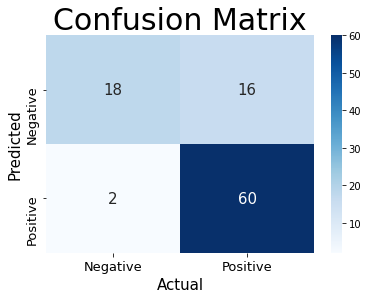

In [86]:
decision_accuracy = decisionTree.score(Xtest, ytest)
print("Accuracy : ", decision_accuracy)
yPred = decisionTree.predict(Xtest)

cm = confusion_matrix(ytest, yPred)
decision_f1 = f1_score(ytest,yPred)
print("F1 Score: " , decision_f1)

# scores.append(["Decision Tree", decision_accuracy, decision_f1])


axis = ['Negative', 'Positive']
data_cm = pd.DataFrame(cm, columns=axis, index=axis)

sb.heatmap(data_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 15})
plt.title('Confusion Matrix', fontsize=30)
plt.xlabel('Actual', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Predicted', fontsize=15)
plt.yticks(fontsize=13)
plt.show()

# KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

params = {'n_neighbors' : [3,4,5,6,7,8,9,10], 
          'algorithm': ['brute', 'ball_tree', 'kd_tree'], 
          'p' : [1,2,3]}

cross_validation = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

gridSearch = GridSearchCV(knn, param_grid=params, cv=cross_validation)

gridSearch.fit(Xtrain, ytrain)

knn = gridSearch.best_estimator_

print('Best score: {}'.format(gridSearch.best_score_))
print('Best parameters: {}'.format(gridSearch.best_params_))
print('Best classifier: {}'.format(knn))

Best score: 0.7237516869095816
Best parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1}
Best classifier: KNeighborsClassifier(algorithm='brute', n_neighbors=3, p=1)


Accuracy :  0.7083333333333334
F1 Score :  0.791044776119403


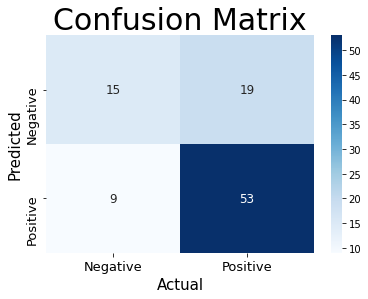

In [90]:
knn_accuracy = knn.score(Xtest, ytest)
print("Accuracy : ", knn_accuracy)
yPred = knn.predict(Xtest)

# Calculate the confusion matrix
cm = confusion_matrix(ytest, yPred)
knn_f1 = f1_score(ytest,yPred)
print("F1 Score : ", knn_f1)

# scores.append(["KNN", knn_accuracy, knn_f1])


axis = ['Negative', 'Positive']
data_cm = pd.DataFrame(cm, columns=axis, index=axis)

sb.heatmap(data_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=30)
plt.xlabel('Actual', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Predicted', fontsize=15)
plt.yticks(fontsize=13)
plt.show()

In [93]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()

params = {'penalty': ['l2'],
          'C': [1,10,100]}

cross_validation = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

gridSearch = GridSearchCV(logReg, param_grid=params, cv=cross_validation)

gridSearch.fit(Xtrain, ytrain)
logReg = gridSearch.best_estimator_

print('Best score: {}'.format(gridSearch.best_score_))
print('Best parameters: {}'.format(gridSearch.best_params_))
print('Best classifier: {}'.format(logReg))

Best score: 0.8050607287449392
Best parameters: {'C': 1, 'penalty': 'l2'}
Best classifier: LogisticRegression(C=1)


In [94]:
features_non_zero = np.abs(logReg.coef_) != 0

Xtrain_refeatured = Xtrain.iloc[:, features_non_zero.squeeze()]

logReg_refeatured = LogisticRegression()

gridSearch = GridSearchCV(logReg_refeatured, param_grid=params, cv=cross_validation)

gridSearch.fit(Xtrain_refeatured, ytrain)

logReg_refeatured = gridSearch.best_estimator_

print('Best score: {}'.format(gridSearch.best_score_))
print('Best parameters: {}'.format(gridSearch.best_params_))
print('Best classifier: {}'.format(logReg_refeatured))

Best score: 0.8050607287449392
Best parameters: {'C': 1, 'penalty': 'l2'}
Best classifier: LogisticRegression(C=1)


Accuracy :  0.8229166666666666
F1 Score :  0.8759124087591241


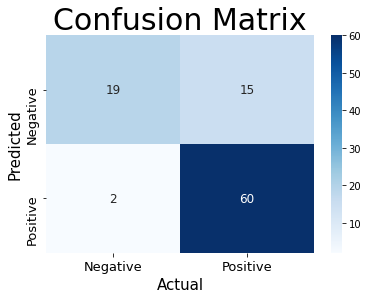

In [97]:
Xtest_subset = Xtest.iloc[:, features_non_zero.squeeze()]

logReg_refeatured_accuracy = logReg_refeatured.score(Xtest_subset, ytest)
print("Accuracy : ", logReg_refeatured_accuracy)
yPred = logReg_refeatured.predict(Xtest_subset)

cm = confusion_matrix(ytest, yPred)
logReg_refeatured_f1 = f1_score(ytest,yPred)
print("F1 Score : ", logReg_refeatured_f1 )

# scores.append(["Logistic Regression - Refeatured", logReg_refeatured_accuracy, logReg_refeatured_f1])


# axis = ['Positive', 'Negative']
axis = ['Negative', 'Positive']
data_cm = pd.DataFrame(cm, columns=axis, index=axis)

sb.heatmap(data_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=30)
plt.xlabel('Actual', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Predicted', fontsize=15)
plt.yticks(fontsize=13)
plt.show()

In [98]:
from sklearn.ensemble import RandomForestClassifier

randForrest = RandomForestClassifier(random_state = seed)

params = {'n_estimators': [30,40,50,60,70],
          'criterion' : ['gini', 'entropy'], 
          'max_features' : ['sqrt','log2']}

cross_validation = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)

gridSearch = GridSearchCV(randForrest, param_grid=params, cv=cross_validation)

gridSearch.fit(Xtrain, ytrain)
randForrest = gridSearch.best_estimator_

print('Best score: {}'.format(gridSearch.best_score_))
print('Best parameters: {}'.format(gridSearch.best_params_))
print('Best classifier: {}'.format(randForrest))
# print('Important features : {}'.format(randForrest.feature_importances_.sort()))

Best score: 0.8101889338731443
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}
Best classifier: RandomForestClassifier(max_features='sqrt', n_estimators=50, random_state=23)


Accuracy :  0.7708333333333334
F1 Score :  0.8333333333333333


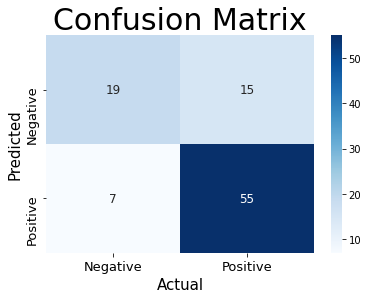

In [102]:
randForrest_accuracy = randForrest.score(Xtest, ytest)
print("Accuracy : ", randForrest_accuracy)
yPred = randForrest.predict(Xtest)

cm = confusion_matrix(ytest, yPred)
randForrest_f1 = f1_score(ytest,yPred)
print("F1 Score : ", randForrest_f1)
# scores.append(["Random Forrest", randForrest_accuracy, randForrest_f1])

axis = ['Negative', 'Positive']
data_cm = pd.DataFrame(cm, columns=axis, index=axis)

sb.heatmap(data_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=30)
plt.xlabel('Actual', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Predicted', fontsize=15)
plt.yticks(fontsize=13)
plt.show()

Classifiers: Decision Tree, KNearest Neighbours, Logistic Regression and RandomForrest.